## Importar dataframes

In [1]:
import pandas as pd

ies = ['Una', 'UniBH', 'Unisociesc', 'USJT', 'Ânima']

list = []

for ies in ies:
    base = pd.read_excel('Downloads/RA %s.xlsx' % ies, skiprows = 3).iloc[:, :-1]
    column = ['Empresa']
    [column.append(col) for col in base.columns.tolist()]
    base['Empresa'] = [ies for i in range(len(base))]
    base = base[column]
    list.append(base)
    
base = pd.concat(list)
display(base.head(5).sort_index())

,Empresa,Id HugMe,Origem,Id Origem,Data Reclamação,Status Hugme,Status RA,Arquivado ?,Congelado?,Título,...,Moderação usuário que solicitou,Moderação data da resposta,Tipo Hugme,Data fechamento,Quantidade interações consumidor,Quantidade interações empresa,Feed tipo,Fonte informação tipo,Histórico,Canal
0,Una,28609971,ReclameAQUI,96557163,2019-10-30 08:54:12,Novo,Não respondido,Não,Não,Falta de acesso ao U Life,...,NaN,NaT,NaN,NaT,1,0,NaN,RA Reclamação,action: INTERACAO\ndata: 30/10/2019 08:54:54\n...,NaN
1,Una,28600751,ReclameAQUI,96537423,2019-10-29 15:51:26,Respondido,Respondido,Não,Não,Renovação online de livros,...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 15:52:58\n...,NaN
2,Una,28599629,ReclameAQUI,96535013,2019-10-29 15:00:25,Novo,Não respondido,Não,Não,Não tenho acesso ao portal do aluno Ulife,...,NaN,NaT,NaN,NaT,1,0,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 15:01:00\n...,NaN
3,Una,28591130,ReclameAQUI,96521363,2019-10-29 10:19:51,Respondido,Respondido,Não,Não,Portal dos alunos fora do ar,...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 29/10/2019 10:21:06\n...,NaN
4,Una,28582802,ReclameAQUI,96503363,2019-10-28 17:58:49,Respondido,Respondido,Não,Não,"Área do Aluno só vive fora do ar, prejudicando...",...,NaN,NaT,NaN,NaT,1,1,NaN,RA Reclamação,action: INTERACAO\ndata: 28/10/2019 17:58:54\n...,NaN


## Criar dataframe de tags

In [2]:
# tags = pd.DataFrame([[ies, item] for ies in np.unique(base.Empresa) for row in [tag.split(' ; ') for index, tag in base[base.Empresa == ies].Tags.items() if type(tag) == str] for item in row], columns = ['ies', 'tag'])

# df_tags = pd.DataFrame([[ies, tag, tags[tags['ies'] == ies].tag.tolist().count(tag)] for ies in np.unique(tags['ies']) for tag in np.unique(tags[tags['ies'] == ies].tag)], columns = ['ies', 'tag', 'amount'])

# display(df_tags)

In [4]:
import numpy as np

df_tags = pd.DataFrame([[id, base[base['Id HugMe'] == id]['Data Reclamação'].tolist()[0], ies, item] for id in base['Id HugMe'] for ies in np.unique(base.Empresa) for row in [tag.split(' ; ') for index, tag in base[(base.Empresa == ies) & (base['Id HugMe'] == id)].Tags.items() if type(tag) == str] for item in row], columns = ['id', 'data', 'ies', 'tag'])

display(df_tags)

,id,data,ies,tag
0,28570673,2019-10-28 08:36:55,Una,Fies
1,28570673,2019-10-28 08:36:55,Una,Aditamento
2,28555389,2019-10-26 08:08:36,Una,Boleto
3,28555389,2019-10-26 08:08:36,Una,Revisão de boleto
4,28520538,2019-10-24 11:09:33,Una,Acordo
5,28520538,2019-10-24 11:09:33,Una,Acordo realizado
6,28497255,2019-10-23 08:23:40,Una,Núcle de Conclusão Acadêmica
7,28497255,2019-10-23 08:23:40,Una,Certificado de conclusão de curso
8,28429881,2019-10-18 12:48:10,Una,Coordenador
9,28429881,2019-10-18 12:48:10,Una,Dúvidas Geral


## Plotar word cloud



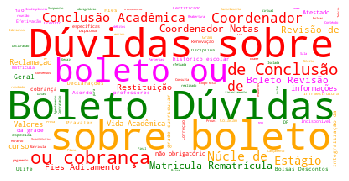

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

mapa_cores = ListedColormap(['orange', 'green', 'red', 'magenta'])

wordcloud = WordCloud(background_color = 'white',
                      colormap = mapa_cores,
                      max_words = 100)

wordcloud.generate(' '.join(df_tags.tag.tolist()))
%matplotlib inline
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Instalar pacote

In [5]:
! pip install gspread_dataframe

## Configurar spreadsheet

In [6]:
import gspread_dataframe as gd
from oauth2client.service_account import ServiceAccountCredentials
import gspread

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('Documents/BLiP to G-Sheets.json', scope)
gc = gspread.authorize(credentials)

## Abrir spreadsheet

In [7]:
ws = gc.open_by_key('1BtFgYqVlgy5mDRpdyi62J0D4CfFBgsbOAnQUDspflSE')

## Limpar worksheet

In [8]:
ws.worksheet('Sheet1').resize(rows = 1)
ws.worksheet('Sheet2').resize(rows = 1)

{'spreadsheetId': '1BtFgYqVlgy5mDRpdyi62J0D4CfFBgsbOAnQUDspflSE',
 'replies': [{}]}

## Alimentar worksheet

In [9]:
gd.set_with_dataframe(ws.worksheet('Sheet1'), base)
gd.set_with_dataframe(ws.worksheet('Sheet2'), df_tags)